In [1]:
import os

from tqdm import tqdm
from glob import glob

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler, PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, PredictionErrorDisplay
from sklearn.linear_model import LinearRegression, ElasticNet, Ridge, Lasso, RANSACRegressor
from sklearn.model_selection import cross_val_score, KFold, train_test_split, GridSearchCV
from sklearn.decomposition import PCA
from sklearn.compose import TransformedTargetRegressor
from sklearn.pipeline import make_pipeline
from yellowbrick.regressor import PredictionError, residuals_plot
from feature_extraction import extract_features_from_images
from sklearn.cross_decomposition import PLSRegression

In [2]:
import warnings
warnings.filterwarnings('ignore')

plt.style.use('default')
plt.style.use('ggplot')

In [3]:
def handle_model_evaluate(true, predicted, title_column=""):  
    
    mae = mean_absolute_error(true, predicted)
    r2_square = r2_score(true, predicted)
    
    return pd.DataFrame({
        f"{title_column}": [
            mae, 
            r2_square],
    },
        index=[
            "MAE",
            "R-squared"
        ])
    
def show_model_performance(model, X_train, y_train, X_test, y_test):
    
    train = handle_model_evaluate(y_train, model.predict(X_train), "Treino")
    test  = handle_model_evaluate(y_test, model.predict(X_test), "Teste")
    
    display(pd.concat([train, test], axis=1))

## Extraindo Features das imagens mascaras

In [4]:
def load_dataset(base_path):
    
    *_, base_path_last = base_path.split("/")
    features_file_name = f"{base_path_last}_features.csv"
    
    if not os.path.isfile(features_file_name):
        extract_features_from_images(
            images_arr=[],
            images_path=f"{base_path}/masks",
            output_file_name=features_file_name,
            resize_shape=(224, 224))
    
    weights = pd.read_csv(f"{base_path}/annotations.csv")
    features = pd.read_csv(features_file_name)

    weights.index = weights.img
    features.index = features.label

    weights = weights.drop('img', axis=1)
    features = features.drop('label', axis=1)
    
    data = pd.concat([weights, features],
                     axis=1,
                     ignore_index=False, 
                     verify_integrity=True)

    data = data.reset_index()
    
    return data

In [5]:
train = load_dataset("data/coletas/combined_v2")
test = load_dataset("data/coletas/Dia 29-11-2022 - OK")

In [6]:
train.specie.value_counts()

tambaqui    73
tilápia     60
curimatã    18
panga        7
traíra       5
lambari      3
Name: specie, dtype: int64

In [7]:
test.specie.value_counts()

tambaqui    75
curimatã     2
panga        1
tilápia      1
Name: specie, dtype: int64

In [8]:
enc = LabelEncoder().fit(train.specie.to_list() + test.specie.to_list())
train.specie = enc.transform(train.specie.values)
test.specie = enc.transform(test.specie.values)

In [9]:
corrmat = train.corr()
corrmat[corrmat.weight < 0].weight

specie                -0.511426
bbox-0                -0.369371
bbox-1                -0.579059
moments_central-1-1   -0.227727
moments_central-1-2   -0.347628
moments_central-1-3   -0.392254
moments_central-2-1   -0.446015
moments_central-2-3   -0.003000
moments_central-3-1   -0.081582
moments_central-3-3   -0.323219
orientation           -0.131475
Name: weight, dtype: float64

In [10]:
corrmat[corrmat.weight > 0].weight

weight                 1.000000
width                  0.772038
length                 0.862963
area                   0.954241
bbox-2                 0.355345
bbox-3                 0.597043
bbox_area              0.948547
centroid-0             0.012084
centroid-1             0.013135
convex_area            0.951091
eccentricity           0.055461
equivalent_diameter    0.918355
euler_number           0.056988
extent                 0.025896
filled_area            0.954241
major_axis_length      0.885280
minor_axis_length      0.818823
moments-0-0            0.954241
moments-0-1            0.962304
moments-0-2            0.946921
moments-0-3            0.925326
moments-1-0            0.935787
moments-1-1            0.941119
moments-1-2            0.927716
moments-1-3            0.908200
moments-2-0            0.887445
moments-2-1            0.885396
moments-2-2            0.869973
moments-2-3            0.850189
moments-3-0            0.817725
moments-3-1            0.807975
moments-

In [11]:
features_names = list(dict(corrmat[corrmat.weight > 0.9].weight).keys())

In [12]:
features_names.remove("weight")
# features_names.append("specie")

In [13]:
X_train, X_test, y_train, y_test, index_train, index_test = (train[features_names].values, 
                                                             test[features_names].values, 
                                                             train.weight.values,
                                                             test.weight.values,
                                                             train["index"].tolist(),
                                                             test["index"].tolist())

In [14]:
scaler = StandardScaler()

X_train_scaled, X_test_scaled = scaler.fit_transform(X_train), scaler.transform(X_test)

In [15]:
def run_all_algs(X_train, y_train, X_test, y_test):

    models = {
        "GradientBoostingRegressor": GradientBoostingRegressor(),
        "AdaBoostRegressor": AdaBoostRegressor(),
        "[LinearRegression]": LinearRegression(),
        "[LassoRegression]": Lasso(),
        "[RidgeRegression]": Ridge(),
        "[RandomForestRegressor]": RandomForestRegressor(),
        "ElasticNet": ElasticNet(),
        "[RANSACRegressor]": RANSACRegressor(),
        "[PLSRegression]": PLSRegression(n_components=2),
        "[PCARegression]": make_pipeline(PCA(n_components=2), LinearRegression()),
        "[PolyRegression]": make_pipeline(PolynomialFeatures(degree=2), 
                                        LinearRegression(fit_intercept=False)),
        "XGBRegressor": XGBRegressor()
    }
    
    for name, model in models.items():

        model.fit(X_train, y_train)
        
        print("\n","\b"+name)
        
        show_model_performance(model,
                               X_train,
                               y_train,
                               X_test,
                               y_test)

        print("_" * 20)

### Features Não Normalizadas

In [16]:
run_all_algs(X_train, y_train, X_test, y_test)


GradientBoostingRegressor


,Treino,Teste
MAE,10.394652,18.365193
R-squared,0.997891,0.908248


____________________

AdaBoostRegressor


,Treino,Teste
MAE,35.228744,19.767191
R-squared,0.977029,0.959993


____________________

[LinearRegression]


,Treino,Teste
MAE,37.328635,22.649136
R-squared,0.946188,0.957080


____________________

[LassoRegression]


,Treino,Teste
MAE,38.363991,24.692499
R-squared,0.944363,0.948331


____________________

[RidgeRegression]


,Treino,Teste
MAE,37.313529,22.609988
R-squared,0.946188,0.957193


____________________

[RandomForestRegressor]


,Treino,Teste
MAE,16.688361,13.644810
R-squared,0.990339,0.947383


____________________

ElasticNet


,Treino,Teste
MAE,38.225226,24.683919
R-squared,0.944266,0.948104


____________________

[RANSACRegressor]


,Treino,Teste
MAE,41.333257,22.867680
R-squared,0.905879,0.937615


____________________

[PLSRegression]


,Treino,Teste
MAE,47.215687,18.939618
R-squared,0.924475,0.964322


____________________

[PCARegression]


,Treino,Teste
MAE,73.527984,39.232675
R-squared,0.856660,0.860343


____________________

[PolyRegression]


,Treino,Teste
MAE,34.832356,85.905993
R-squared,0.972875,-5.534840


____________________

XGBRegressor


,Treino,Teste
MAE,0.068693,22.100110
R-squared,1.000000,0.835677


____________________


### Features Normalizadas

In [17]:
run_all_algs(X_train_scaled, y_train, X_test_scaled, y_test)


GradientBoostingRegressor


,Treino,Teste
MAE,10.394652,18.228542
R-squared,0.997891,0.907532


____________________

AdaBoostRegressor


,Treino,Teste
MAE,33.453935,19.057338
R-squared,0.978876,0.943313


____________________

[LinearRegression]


,Treino,Teste
MAE,37.328636,22.649137
R-squared,0.946188,0.957080


____________________

[LassoRegression]


,Treino,Teste
MAE,44.190137,21.719078
R-squared,0.930636,0.955893


____________________

[RidgeRegression]


,Treino,Teste
MAE,40.719091,20.406157
R-squared,0.937090,0.963191


____________________

[RandomForestRegressor]


,Treino,Teste
MAE,16.006072,12.561772
R-squared,0.987933,0.970092


____________________

ElasticNet


,Treino,Teste
MAE,50.222509,22.330325
R-squared,0.921337,0.952111


____________________

[RANSACRegressor]


,Treino,Teste
MAE,37.009482,25.023275
R-squared,0.937674,0.928386


____________________

[PLSRegression]


,Treino,Teste
MAE,47.215687,18.939618
R-squared,0.924475,0.964322


____________________

[PCARegression]


,Treino,Teste
MAE,50.536958,19.571486
R-squared,0.921360,0.959815


____________________

[PolyRegression]


,Treino,Teste
MAE,9.700269,86.195306
R-squared,0.997290,-6.569257


____________________

XGBRegressor


,Treino,Teste
MAE,0.068693,22.100110
R-squared,1.000000,0.835677


____________________


In [18]:
model = RandomForestRegressor(n_estimators=1000, max_depth=9,random_state=0, n_jobs=-1).fit(X_train_scaled, y_train)

In [19]:
show_model_performance(model, X_train_scaled, y_train, X_test_scaled, y_test)

,Treino,Teste
MAE,16.571450,13.034678
R-squared,0.989114,0.961640


In [20]:
import math
syntetic = pd.DataFrame({
    "ACTUAL": y_test,
    "PREDICTED_VALUES": np.rint(model.predict(X_test_scaled)).astype(int),
})

syntetic["ERROR_ABS"] = abs(syntetic["ACTUAL"] - syntetic["PREDICTED_VALUES"])
syntetic["MEAN_VALUES"] = np.rint((syntetic["ACTUAL"] + syntetic["PREDICTED_VALUES"]) / 2).astype(int)

In [21]:
syntetic

,ACTUAL,PREDICTED_VALUES,ERROR_ABS,MEAN_VALUES
0,265,275,10,270
1,337,339,2,338
2,258,261,3,260
3,228,231,3,230
4,448,457,9,452
...,...,...,...,...
74,532,545,13,538
75,334,358,24,346
76,336,363,27,350
77,244,244,0,244


In [22]:
# syntetic.to_csv("syntetic.csv")

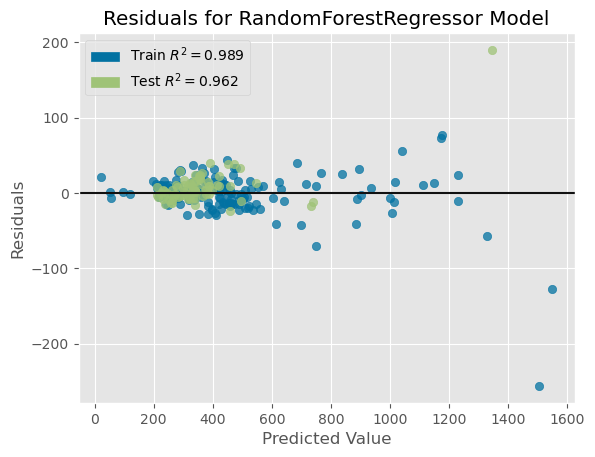

In [23]:
viz = residuals_plot(model, 
                     X_train_scaled, 
                     y_train, 
                     X_test_scaled, 
                     y_test,
                     hist=False)

viz.show();

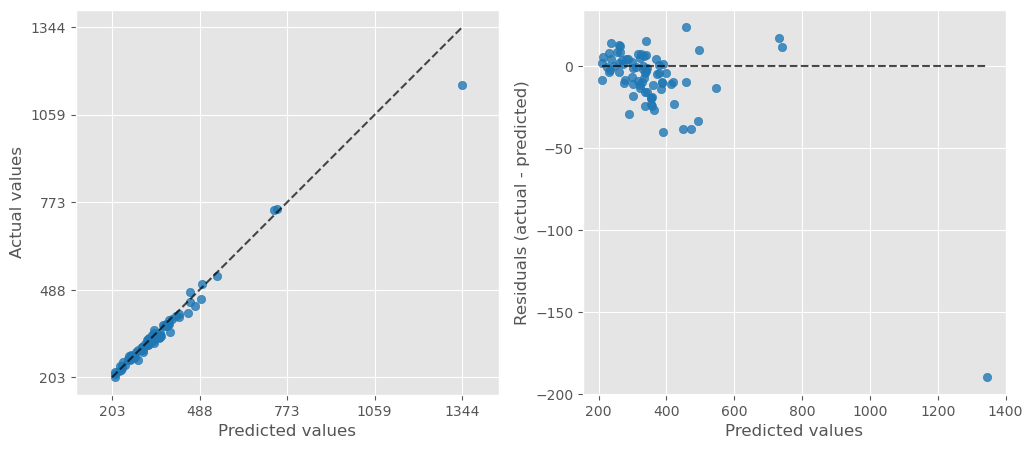

In [24]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

PredictionErrorDisplay.from_estimator(
    model, 
    X_test_scaled,
    y_test,
    kind="actual_vs_predicted",
    ax=axs[0]
);

PredictionErrorDisplay.from_estimator(
    model,
    X_test_scaled,
    y_test,
    kind="residual_vs_predicted", 
    ax=axs[1]
);